In [10]:
import os
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<b>Step 1.</b> Create your own custom dataset featuring 3 custom categories of at least 100 images each

I have made a custom dataset of Animals, which consists of 3 categories of animals: Wild animals, Birds and Aquatic animals of at least 100 images each

In [12]:
# Preprocessing the Data
transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resizing images to 224x224
    transforms.ToTensor(),               # Converting images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing images
])

# Define data directory
data_directory = '/content/drive/MyDrive/Custom_dataset'

# Load the dataset
ani_bird_aqua_dataset = ImageFolder(data_directory, transform=transform)

<b>Step 2.</b> Split this data between 80% training and 20% test




In [13]:
# Divivding the Training and Testing sets
dataset_size = len(ani_bird_aqua_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(ani_bird_aqua_dataset, [train_size, test_size])

# Data loaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<b>Step 3.</b> Preprocess the data as you see fit

In [14]:
# Adding some more transformations as a part of preprocessing
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
])

# Applying transformations to the datasets
train_dataset.transform = train_transform



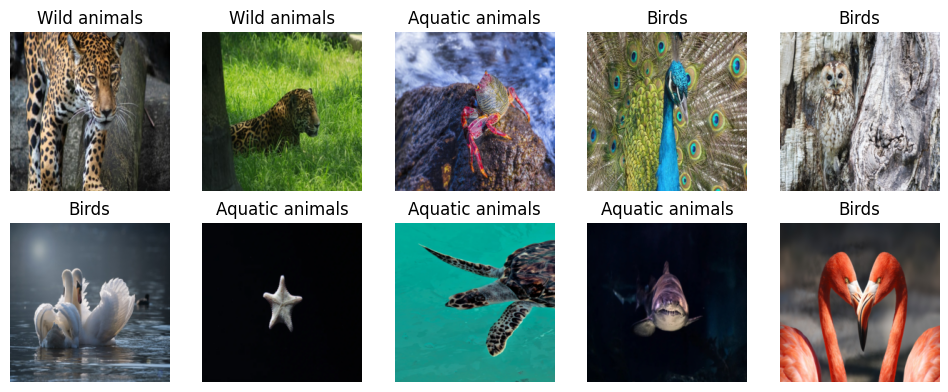

In [15]:
# Displaying the first 10 images and labels from the training dataset
images, labels = [], []
for i in range(10):
    image, label = train_dataset[i]
    images.append(image)
    labels.append(label)

# Reversing the Transformations that I have done above
images = torch.stack(images).numpy()  # Converting PyTorch tensor to numpy array
images = np.transpose(images, (0, 2, 3, 1))  # Change shape from (N, C, H, W) to (N, H, W, C)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = np.clip(std * images + mean, 0, 1)  # Unnormaliz ingimages

# My custom dataset consists of these Classes
class_names = ['Aquatic animals', 'Birds','Wild animals' ]

# Plotting the images
plt.figure(figsize=(12,12))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.show()


<b>Step 4.</b> Create a Convolutional Neural Network model to learn about your training set


In [16]:
# Building the convolution neural network model

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # Adjust input size based on your image dimensions
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)  # Adjust input size based on your image dimensions
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
# Initializing the model
num_classes = len(ani_bird_aqua_dataset.classes)
model = CNNModel(num_classes)

In [18]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

print('Finished Training')

Epoch 1/10, Loss: 2.7094334810972214
Epoch 2/10, Loss: 0.9759263917803764
Epoch 3/10, Loss: 0.8082170188426971
Epoch 4/10, Loss: 0.71297437697649
Epoch 5/10, Loss: 0.6644562780857086
Epoch 6/10, Loss: 0.5213154181838036
Epoch 7/10, Loss: 0.418872456997633
Epoch 8/10, Loss: 0.32075178623199463
Epoch 9/10, Loss: 0.21849173307418823
Epoch 10/10, Loss: 0.14778073551133275
Finished Training


<b>Step 5.</b> Make predictions on the test data and compare them to the expected categories


In [19]:
# Evaluating the Model using test dataset
model.eval()

# List for predicted and ground truth labels
predicted_labels = []
ground_truth_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())  # Convert predictions to numpy array
        ground_truth_labels.extend(labels.cpu().numpy())  # Convert ground truth labels to numpy array

# Converting class indices to class labels
class_labels = ani_bird_aqua_dataset.classes
predicted_labels = [class_labels[label] for label in predicted_labels]
ground_truth_labels = [class_labels[label] for label in ground_truth_labels]

# Comparing predicted labels with ground truth labels
for predicted, ground_truth in zip(predicted_labels, ground_truth_labels):
    print(f"Predicted: {predicted}, Ground Truth: {ground_truth}")

# Calculating accuracy
correct = sum(1 for p, g in zip(predicted_labels, ground_truth_labels) if p == g)
total = len(ground_truth_labels)
accuracy = correct / total
print(f"\nAccuracy on the test set: {accuracy * 100:.2f}%")


Predicted: wild_animals, Ground Truth: wild_animals
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: acquatic_animals, Ground Truth: birds
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: birds, Ground Truth: birds
Predicted: birds, Ground Truth: birds
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: acquatic_animals, Ground Truth: wild_animals
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: birds, Ground Truth: birds
Predicted: birds, Ground Truth: wild_animals
Predicted: birds, Ground Truth: birds
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: acquatic_animal

<b>
Step 6:</b> Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.


In [20]:
# Load the pre-trained GoogleNet model
googlenet = models.googlenet(pretrained=True)

# Freezing all layers in the model
for param in googlenet.parameters():
    param.requires_grad = False

# Modifying the classifier to add a linear layer on top
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(ani_bird_aqua_dataset.classes))  # Adjust output size based on the number of classes in your dataset
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.fc.parameters(), lr=0.001)

# Training the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet.to(device)
googlenet.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 111MB/s]


Epoch 1/10, Loss: 0.9712007567286491
Epoch 2/10, Loss: 0.5283459834754467
Epoch 3/10, Loss: 0.314743896946311
Epoch 4/10, Loss: 0.20145156793296337
Epoch 5/10, Loss: 0.1259872429072857
Epoch 6/10, Loss: 0.12176379188895226
Epoch 7/10, Loss: 0.08185432525351644
Epoch 8/10, Loss: 0.12588443979620934
Epoch 9/10, Loss: 0.12452200753614306
Epoch 10/10, Loss: 0.0669634744990617
Finished Training


<b>Step 7:</b> Train the GoogleNet model and compare the accuracy with the first model.

In [21]:
# Evaluating the Googlenet Model
googlenet.eval()

# Comparing predictions with ground truth labels
predicted_labels = []
ground_truth_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = googlenet(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.tolist())
        ground_truth_labels.extend(labels.tolist())

# Converting class indices to class labels
class_labels = ani_bird_aqua_dataset.classes
predicted_labels = [class_labels[label] for label in predicted_labels]
ground_truth_labels = [class_labels[label] for label in ground_truth_labels]

# Comparing predicted labels with ground truth labels
for predicted, ground_truth in zip(predicted_labels, ground_truth_labels):
    print(f"Predicted: {predicted}, Ground Truth: {ground_truth}")

# Calculating accuracy
correct = sum(1 for p, g in zip(predicted_labels, ground_truth_labels) if p == g)
total = len(ground_truth_labels)
accuracy = correct / total
print(f"\nAccuracy of the GoogLeNet model on the test set: {accuracy * 100:.2f}%")

Predicted: wild_animals, Ground Truth: wild_animals
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: acquatic_animals, Ground Truth: birds
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: birds, Ground Truth: birds
Predicted: birds, Ground Truth: birds
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: birds, Ground Truth: birds
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: birds, Ground Truth: birds
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: wild_animals, Ground Truth: wild_animals
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: acquatic_animals, Ground Truth: acquatic_animals
Predicted: acquatic_ani

Accuracy for google net model is higher than the first model.

Googlenet model is attributed with Pre-trained weights and have a deeper architecture than the CNN I have built. This might be a possible reason for the increase in accuracy.